# Talking Heads

Use AWS services (and open source models) to generate a "talking heads" style news show. This script uses:

- Amazon SageMaker
- Amazon Polly
- Amazon Bedrock

**Note: This script is designed to run in SageMaker Studio**. You may need to make changes to run it locally. If you want to run on an Amazon SageMaker Notebook Instance, you will have to find alternative methods to install some dependencies (such as `ffmpeg`).

In [ ]:
## Install dependencies

Run the code below to install required dependencies and set up a directory structure for storing outputs 

In [ ]:
# First things first, let's set up a new directory for the AWS demo, and 
# change context into that directory

# Let's start by creating a new directory to store outputs
!mkdir -p outputs
%cd outputs


!mkdir -p ~/dialogues/awsdemo
%cd ~/dialogues/awsdemo

/home/sagemaker-user/dialogues/awsdemo


In [ ]:
# Handle imports
!pip install -U 'stability-sdk[sagemaker] @ git+https://github.com/Stability-AI/stability-sdk.git@sagemaker'
!pip install protobuf==3.20

# Use IPython to display the audio files, for testing
from IPython.display import Audio, display, HTML

import sagemaker
from sagemaker import ModelPackage, get_execution_role
from stability_sdk_sagemaker.predictor import StabilityPredictor
from stability_sdk_sagemaker.models import get_model_package_arn
from stability_sdk.api import GenerationRequest, GenerationResponse, TextPrompt

from PIL import Image
from typing import Union, Tuple
import io
import os
import base64
import boto3
import json


  Cloning https://github.com/Stability-AI/stability-sdk.git (to revision sagemaker) to /tmp/pip-install-2y_ayx1e/stability-sdk_7027b1607b1a412d91b7cbbab3397924
  Running command git clone --filter=blob:none --quiet https://github.com/Stability-AI/stability-sdk.git /tmp/pip-install-2y_ayx1e/stability-sdk_7027b1607b1a412d91b7cbbab3397924
  Running command git checkout -b sagemaker --track origin/sagemaker
  Switched to a new branch 'sagemaker'
  Branch 'sagemaker' set up to track remote branch 'sagemaker' from 'origin'.
  Resolved https://github.com/Stability-AI/stability-sdk.git to commit 41773a9366d3bef3d32f59c7ff1d1939fbe5212e
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.10/site-packages/pydantic-1.10.13.dist-info/METADATA'


In [ ]:
# Get execution role and set up session so SageMaker can talk to the SDXL model endpoint
sagemaker_session = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [ ]:
# Set model ARN and access the model name
endpoint_name = "jumpstart-dft-stabilityai-sdxl-1-0-20240118-094252"
deployed_model = StabilityPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)

In [ ]:
# Helper function to decode images
def decode_and_show(filepath, model_response: GenerationResponse) -> None:
    
    image = model_response.artifacts[0].base64
    image_data = base64.b64decode(image.encode())
    image = Image.open(io.BytesIO(image_data))

    image.save(filepath, format="JPEG")
    
    display(image)


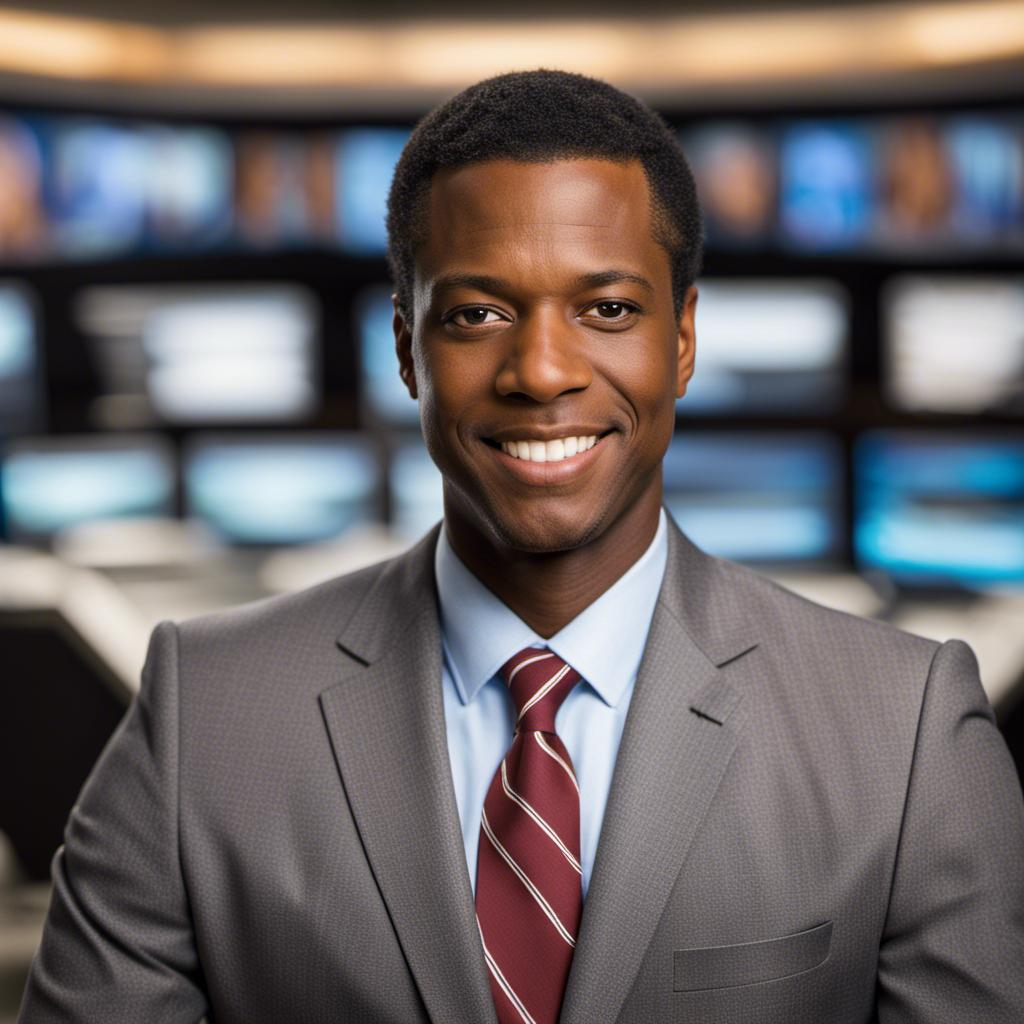

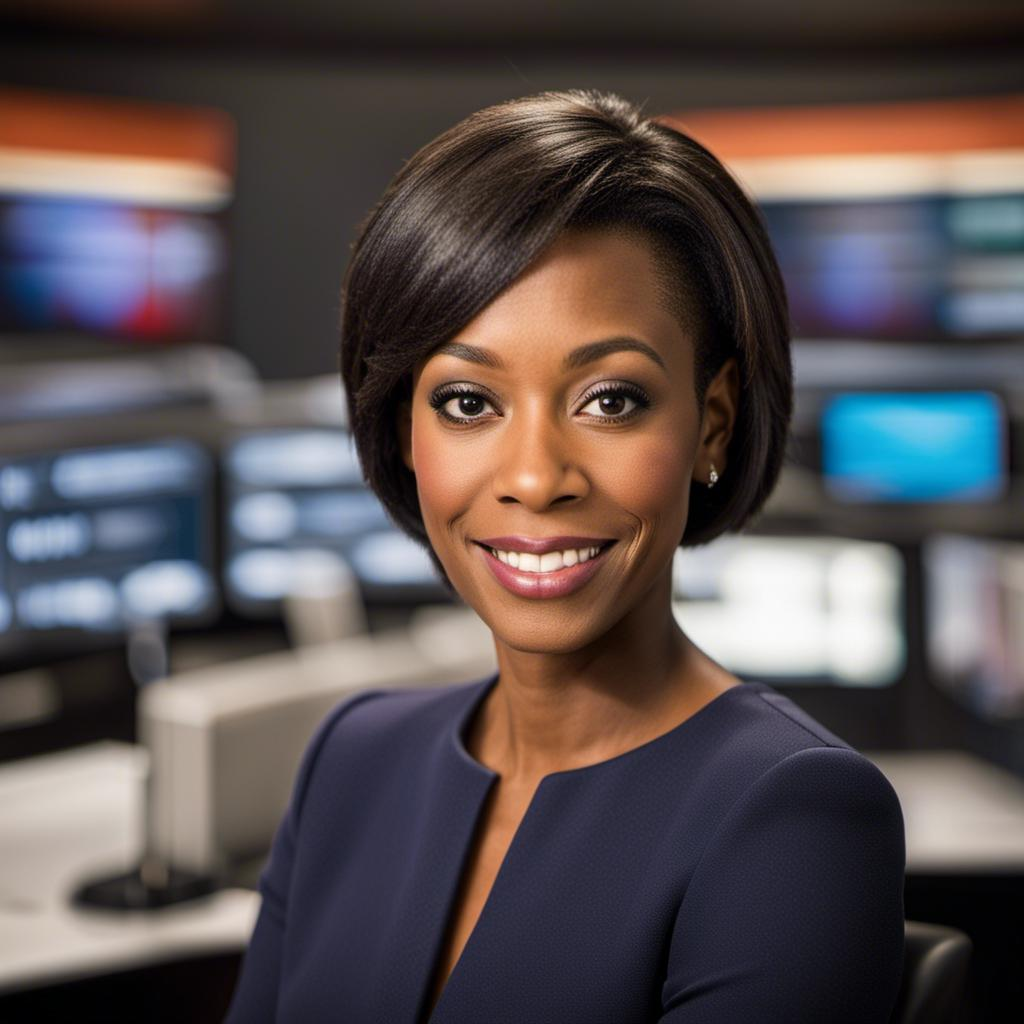

In [ ]:
# Make an inference
regenerate_man = False
regenerate_woman = False

if regenerate_man:
    male_prompt = 'Headshot of a male african-american newscaster with short hair sitting behind a news desk, photographed from the front, looking straight into the camera.',
    
    male_output = deployed_model.predict(
        GenerationRequest(
            text_prompts=[TextPrompt(text=f"{male_prompt}")],
            style_preset="enhance",
            seed=4444,
            width=1024,
            height=1024.0,
        )
    )
  
    decode_and_show("male.jpg", male_output)    
else:
    man = Image.open('male.jpg')
    display(man)

if regenerate_woman: 
    female_output = deployed_model.predict(
        GenerationRequest(
            text_prompts=[TextPrompt(text=f"{female_prompt}")],
            style_preset="enhance",
            seed=1234,
            width=1024,
            height=1024.0,
        )
    )
    
    decode_and_show("female.jpg", female_output)  
else:
    woman = Image.open('female.jpg')
    display(woman)

In [ ]:
# Generate dialogue
topic = "are long distance relationships difficult?"
prompt = f"\"\n\nHuman: Please write a script for a man and a woman, discussing the topic '{topic}'. The script should include dialogue only, no directions for actors or crew. The script should have a clear ending. The man and woman should take turns talking in the script, like this:\n\nMan: Hello\nWoman: Hello\n\nAssistant:\""

# Print out prompt for reference
print(prompt)

"

Human: Please write a script for a man and a woman, discussing the topic 'are long distance relationships difficult?'. The script should include dialogue only, no directions for actors or crew. The script should have a clear ending. The man and woman should take turns talking in the script, like this:

Man: Hello
Woman: Hello

Assistant:"


In [ ]:
# Generate the dialogue and print it out

brt = boto3.client(service_name='bedrock-runtime')

body = json.dumps({
    "prompt": f"{prompt}",
    "max_tokens_to_sample": 500,
    "temperature": 0.1,
    "top_p": 0.9,
})

modelId = 'anthropic.claude-v2'
accept = 'application/json'
contentType = 'application/json'

response = brt.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)

response_body = json.loads(response.get('body').read())

# text
print(response_body.get('completion'))

 Here is a sample script with dialogue between a man and a woman discussing whether long distance relationships are difficult:

Man: So what do you think about long distance relationships? Do you think they can really work?

Woman: I think they can work but they're definitely more challenging than a normal relationship where you get to see each other every day. 

Man: Yeah, I agree. Not being able to see your partner regularly must make things a lot harder.

Woman: For sure. You miss out on so much of the day-to-day stuff and the physical intimacy. Trying to maintain a connection through video chats and texts isn't the same.

Man: Totally. I feel like long distance relationships take a lot more effort to stay connected. You really have to be committed and put in work. 

Woman: Exactly. Both people have to be willing to make sacrifices and compromises too. It's not easy when you're living separate lives in different places. 

Man: Do you think long distance relationships can last in the

In [ ]:
# Pull out the text
text = response_body.get('completion')

# Convert to a set of stripped lines
text = [line.strip() for line in text.split('\n')]

# Remove lines that don't start with 'Man:' or 'Woman:'
text = [line for line in text if line.startswith('Man:') or line.startswith('Woman:')]

# Print results
for line in text:
    print(line)

Man: So what do you think about long distance relationships? Do you think they can really work?
Woman: I think they can work but they're definitely more challenging than a normal relationship where you get to see each other every day.
Man: Yeah, I agree. Not being able to see your partner regularly must make things a lot harder.
Woman: For sure. You miss out on so much of the day-to-day stuff and the physical intimacy. Trying to maintain a connection through video chats and texts isn't the same.
Man: Totally. I feel like long distance relationships take a lot more effort to stay connected. You really have to be committed and put in work.
Woman: Exactly. Both people have to be willing to make sacrifices and compromises too. It's not easy when you're living separate lives in different places.
Man: Do you think long distance relationships can last in the long run? Or are they mostly just temporary?
Woman: I think it depends on the couple. Some long distance relationships definitely do lea

In [ ]:
# Helper function for generating audio
def synthesize_speech(client, text, voice, output_file):
    
    # Request speech synthesis
    response = polly_client.synthesize_speech(
        Text=text,
        OutputFormat='mp3',
        VoiceId=voice,
        Engine='neural'
    )

    # Save the speech to an MP3 file
    if "AudioStream" in response:
        with open(output_file, 'wb') as file:
            file.write(response['AudioStream'].read())

In [ ]:
# Now we create a new directory to hold our human speech mp3s 
# (which will drive our SadTalker job later on, along with our images)

# Create new dir to hold mp3s
!mkdir -p ~/dialogues/awsdemo/mp3
%cd ~/dialogues/awsdemo/mp3
!rm -rf *.mp3

# Create Polly client
polly_client = boto3.client('polly')

dialogue_details = [] # Save file paths and indices for later
index = 0
for line in text:
    
    # Process dialogue (split the Man: and Woman: headers from the speech itself)
    sex, speech = [item.strip() for item in line.split(':')]

    # Set filenames
    prefix = str(index)
    prefix = prefix.rjust(5, '0')
    output_file = f"{prefix}.mp3"

    print(f"Processing the following line, at index {index}:\n{line}")
    
    # Differentiate voices    
    if sex == 'Man':
        synthesize_speech (polly_client, speech, 'Gregory', output_file)
    if sex == 'Woman':
        synthesize_speech (polly_client, speech, 'Danielle', output_file)

    print(f"Results saved to file {output_file}")
    dialogue_details.append((sex, output_file))
    
    index += 1

/home/sagemaker-user/dialogues/awsdemo/mp3
Processing the following line, at index 0:
Man: So what do you think about long distance relationships? Do you think they can really work?
Results saved to file 00000.mp3
Processing the following line, at index 1:
Woman: I think they can work but they're definitely more challenging than a normal relationship where you get to see each other every day.
Results saved to file 00001.mp3
Processing the following line, at index 2:
Man: Yeah, I agree. Not being able to see your partner regularly must make things a lot harder.
Results saved to file 00002.mp3
Processing the following line, at index 3:
Woman: For sure. You miss out on so much of the day-to-day stuff and the physical intimacy. Trying to maintain a connection through video chats and texts isn't the same.
Results saved to file 00003.mp3
Processing the following line, at index 4:
Man: Totally. I feel like long distance relationships take a lot more effort to stay connected. You really have t

In [ ]:
# Show audio (for debugging purposes)
for sex, audio_path in dialogue_details:  
        # Display a label for the audio file
        display(HTML(f"<b>{sex}: {audio_path}</b>"))

        # Display the audio player for the file
        display(Audio(audio_path))

In [ ]:
# Before our run, make sure libgl is installed
# !sudo apt-get update
# !sudo apt-get install -y libgl1-mesa-glx

In [ ]:
# Make sure ffmpeg is installed too, we will need this for video stitching
!sudo apt-get update
!sudo apt-get install -y ffmpeg

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                      
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
# Handle installing safetensors and other tools required by SadTalker
%cd ~/SadTalker
!pip install -r requirements.txt

/home/sagemaker-user/SadTalker
  Using cached pydantic-2.5.3-py3-none-any.whl.metadata (65 kB)
Using cached pydantic-2.5.3-py3-none-any.whl (381 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.13
ERROR: Cannot uninstall pydantic 1.10.13, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps pydantic==1.10.13'.


In [ ]:
!pip install gfpgan
!pip install realesrgan

In [ ]:
#
# Generate videos
#
debug = False # Set to true to run just ONE generation

# Set base paths for mp3s and images
male_image = '../dialogues/awsdemo/male.jpg'
female_image = '../dialogues/awsdemo/female.jpg'
audio_base = '../dialogues/awsdemo/mp3/'
result_dir = '../dialogues/awsdemo/vid/'

# Take care of some housekeeping
!mkdir -p ../dialogues/awsdemo/vid
!rm -rf ../dialogues/awsdemo/vid/*

i = 0
for sex, audio in dialogue_details:
    
    # Stop after 2 videos
    if debug and i > 1:
        break
    i += 1

    if sex == 'Man':
        image = male_image

    if sex == 'Woman': 
        image = female_image

    # Adjust audio file path as well to include 
    # full path as we are now inside the SadTalker directory
    audio = audio_base + audio
    
    print(f"\nGenerating video for audio file {audio} using image {image}\n")
    !python inference.py --driven_audio {audio} --source_image {image} --preprocess crop --enhancer gfpgan --background_enhancer realesrgan --result_dir {result_dir}
    
print("Done!")


Generating video for audio file ../dialogues/awsdemo/mp3/00000.mp3 using image ../dialogues/awsdemo/male.jpg

2024-01-18 13:02:56.126614: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-18 13:02:56.176141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
using safetensor as default
3DMM Extraction for source image
Face Renderer:: 100%|███████████████████████████| 58/58 [00:29<00:00,  1.96it/s]
The generated video is named ../dialogues/awsdemo/vid/2024_01_18_13.03.07/male##00000.mp4
face enhancer

In [ ]:
# Concatenate the .mp4 files into a single video
%cd ~/dialogues/awsdemo/vid
!rm output.mp4 # Remove leftover output videos
!rm filelist.txt # Remove old file lists
!for f in $(ls *.mp4); do echo "file '$f'" >> filelist.txt; done
!cat filelist.txt # Check the output

In [ ]:
# Produce output video
!ffmpeg -f concat -safe 0 -i filelist.txt -c copy output.mp4

In [ ]:
# Return to dialogues directory
%cd ~/dialogues/awsdemo
print("Done!")